df_t Index(['cell_1', 'cell_2', 'cell_3', 'cell_4', 'cell_5', 'cell_6', 'cell_7',
       'cell_8', 'cell_9', 'cell_10',
       ...
       'cell_7322', 'cell_7323', 'cell_7324', 'cell_7325', 'cell_7326',
       'cell_7327', 'cell_7328', 'cell_7329', 'cell_7330', 'cell_7331'],
      dtype='object', length=1784)
df_t Index(['cell_894', 'cell_895', 'cell_896', 'cell_897', 'cell_898', 'cell_899',
       'cell_900', 'cell_901', 'cell_902', 'cell_903',
       ...
       'cell_8218', 'cell_8219', 'cell_8220', 'cell_8221', 'cell_8222',
       'cell_8223', 'cell_8224', 'cell_8225', 'cell_8226', 'cell_8227'],
      dtype='object', length=2384)
df_t Index(['cell_1788', 'cell_1789', 'cell_1790', 'cell_1791', 'cell_1792',
       'cell_1793', 'cell_1794', 'cell_1795', 'cell_1796', 'cell_1797',
       ...
       'cell_9113', 'cell_9114', 'cell_9115', 'cell_9116', 'cell_9117',
       'cell_9118', 'cell_9119', 'cell_9120', 'cell_9121', 'cell_9122'],
      dtype='object', length=3164)
df_t Index(['cell_2

selected_cells Index(['cell5961', 'cell5962', 'cell5963', 'cell5964', 'cell5965', 'cell5966',
       'cell5967', 'cell5968', 'cell5969', 'cell5970',
       ...
       'cell6431', 'cell6432', 'cell6433', 'cell6434', 'cell6435', 'cell6436',
       'cell6437', 'cell6438', 'cell6439', 'cell6440'],
      dtype='object', length=480)
selected_cells ['cell_5961', 'cell_5962', 'cell_5963', 'cell_5964', 'cell_5965', 'cell_5966', 'cell_5967', 'cell_5968', 'cell_5969', 'cell_5970', 'cell_5971', 'cell_5972', 'cell_5973', 'cell_5974', 'cell_5975', 'cell_5976', 'cell_5977', 'cell_5978', 'cell_5979', 'cell_5980', 'cell_5981', 'cell_5982', 'cell_5983', 'cell_5984', 'cell_5985', 'cell_5986', 'cell_5987', 'cell_5988', 'cell_5989', 'cell_5990', 'cell_5991', 'cell_5992', 'cell_5993', 'cell_5994', 'cell_5995', 'cell_5996', 'cell_5997', 'cell_5998', 'cell_5999', 'cell_6000', 'cell_6001', 'cell_6002', 'cell_6003', 'cell_6004', 'cell_6005', 'cell_6006', 'cell_6007', 'cell_6008', 'cell_6009', 'cell_6010', 'cell

/home/jfwang/miniconda3/envs/SynOT/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jfwang/miniconda3/envs/SynOT/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



UMAP result:
          UMAP1     UMAP2
cell1 -0.057235  6.319049
cell2 -0.196144  6.612747
cell3  0.751717  7.748332
cell4  1.074174  8.018603
cell5  1.971949  7.807164


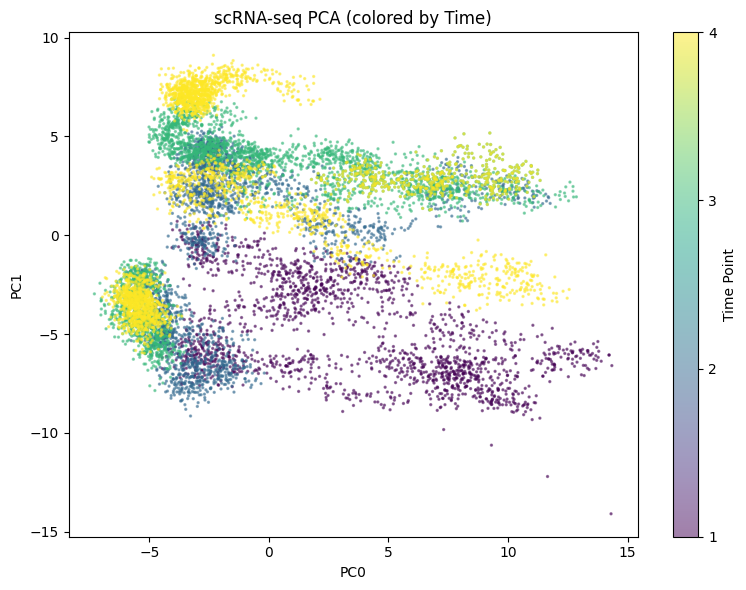

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import joblib  
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data_dir = './FiveBranch'
time_points = [1, 2, 3, 4]


all_RNA_data = []
all_RNA_time_labels = []
all_RNA_cell_index = []


# load meta information to get celltype and pop
meta = pd.read_csv(os.path.join(data_dir, 'complete_meta.csv'), index_col=0)
meta.index = meta.index.str.replace('_', '')  # remove underscore


for t in time_points:
    file_path = os.path.join(data_dir, f'time_{t}_scRNA.csv')
    df = pd.read_csv(file_path, index_col=0)
    df_t = df.T  
    print("df_t", df_t.index)

    if t != 4:
    
        all_RNA_data.append(df_t)
        all_RNA_time_labels.extend([t] * df_t.shape[0])
        all_RNA_cell_index.extend(df_t.index.tolist())

    else:
        previous_path = os.path.join(data_dir, f'time_{t-1}_scRNA.csv')
        previous_df = pd.read_csv(previous_path, index_col=0)
        previous_df_t = previous_df.T

        selected_cells = meta[(meta['pop'].isin(['9_4', '9_5']))].index
        print("selected_cells", selected_cells)
        selected_format = [cell.replace('cell', 'cell_') for cell in selected_cells]
        #selected_cells = [cell for cell in selected_cells if cell in df_t.index]
        print("selected_cells", selected_format)
        duplicated_df = previous_df_t.loc[selected_format]
        print("duplicated_df", duplicated_df.index)
        
        last_df = pd.concat([df_t, duplicated_df], axis=0)
        all_RNA_data.append(last_df)
        all_RNA_time_labels.extend([t] * last_df.shape[0])
        all_RNA_cell_index.extend(last_df.index.tolist())
print(all_RNA_data[3].shape)


RNA_data = pd.concat(all_RNA_data, axis=0)
combined_RNA_data = RNA_data.fillna(0)
combined_RNA_data.index = [idx.replace('_', '') for idx in all_RNA_cell_index]  # cell name as index

print(f"number of cells: {combined_RNA_data.shape[0]}")
print(f"number of genes: {combined_RNA_data.shape[1]}")

# log2 transform + standardize the original count matrix
log_counts = np.log2(combined_RNA_data + 1)
X_scaled = StandardScaler().fit_transform(log_counts.values)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, 'FiveBranch_pca_model.pkl')

# UMAP to 2D random_state=10
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=1.0, random_state=38)
umap_result = umap_reducer.fit_transform(X_pca)


umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"], index=combined_RNA_data.index)

joblib.dump(umap_reducer, 'FiveBranch_umap_model.pkl')
print("\nUMAP result:")
print(umap_df.head())


plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=all_RNA_time_labels, cmap='viridis', alpha=0.5, s=2)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('scRNA-seq PCA (colored by Time)')
cbar = plt.colorbar(scatter, ticks=time_points)
cbar.set_label('Time Point')
plt.tight_layout()
plt.show()

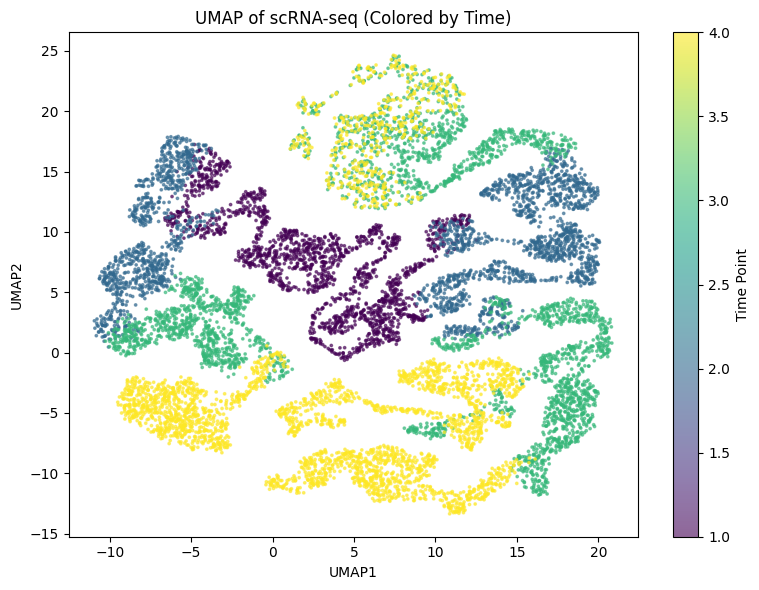

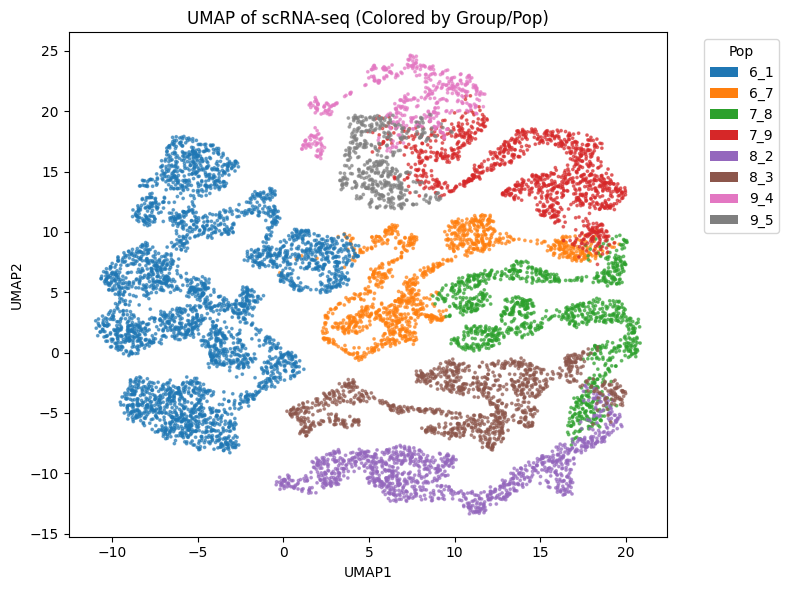

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# construct temporary meta information
umap_df['time'] = all_RNA_time_labels


# visualize 1: colored by time point
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['time'], cmap='viridis', s=3, alpha=0.6)
plt.colorbar(scatter, label='Time Point')
plt.title('UMAP of scRNA-seq (Colored by Time)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

# visualize 2: colored by group (default only one category)

meta = pd.read_csv(os.path.join(data_dir, 'complete_meta.csv'), index_col=0)
meta = meta.loc[combined_RNA_data.index]
pop_labels = meta['pop'].values  # group label
unique_pops = np.unique(pop_labels)
color_list = plt.cm.tab10.colors[:len(unique_pops)]
pop2color = {pop: color for pop, color in zip(unique_pops, color_list)}
cell_RNA_colors = [pop2color[pop] for pop in pop_labels]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=cell_RNA_colors, s=3, alpha=0.6)
legend_elements = [Patch(facecolor=pop2color[pop], label=pop) for pop in unique_pops]
plt.legend(handles=legend_elements, title='Pop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('UMAP of scRNA-seq (Colored by Group/Pop)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()